# DECISION AIDING

In [142]:
%matplotlib inline
import pandas as pd
import numpy as np
import common as cm
import matplotlib.pyplot as plt

This exercise consists of 3 parts. Finish the first part to get a mark of 3.0. The first two parts to get 4.0. Finish all exercies to get 5.0.

# Part 1: Concordance

Given are the following modes of transport: bus, bike, car, train. Each mode is characterized by 2 cost-type criteria: price and time; and 2 gain-type criteria: comfort and reliability. 

Mode of transport | Time | Comfort | Price | Reliability
--- | --- | --- | --- | ---
 **bus**  | 6 | 3  | 6 | 2
 **bike** | 8 | 2  | 2 | 8
 **car**  | 2 | 10 | 9 | 7
 **train**| 3 | 5  | 5 | 6
 **by foot**| 10 | 2  | 0 | 5

In [143]:
data = {
    'mode': ['bus', 'bike', 'car', 'train', 'foot'],
    'time': [6, 8, 2, 3, 10],
    'comfort': [3, 2, 10, 5, 2],
    'price': [6, 2, 9, 5, 0],
    'reliability': [2, 8, 7, 6, 5]
}

criteria = ['time', 'comfort', 'price', 'reliability']

data = pd.DataFrame(data, columns=['mode', 'time', 'comfort', 'price', 'reliability'])
data

,mode,time,comfort,price,reliability
0,bus,6,3,6,2
1,bike,8,2,2,8
2,car,2,10,9,7
3,train,3,5,5,6
4,foot,10,2,0,5


1.2) Below are the parameters, i.e., threholds, criterion-type, and weights, for each criterion, 

In [144]:
parameters = {'time': {'weight': 4, 'q': 1.0, 'p': 2, 'v': 4, 'type': 'cost'},
 'comfort': {'weight': 2, 'q': 2.0, 'p': 3, 'v': 6, 'type': 'gain'},
 'price': {'weight': 3, 'q': 1.0, 'p': 3, 'v': 5, 'type': 'cost'},
 'reliability': {'weight': 1, 'q': 1.5, 'p': 3, 'v': 5, 'type': 'gain'}}

sum_weights = 10.

pd.DataFrame(parameters, columns=['time', 'comfort', 'price','reliability']).reindex(['type', 'q', 'p', 'v', 'weight']).T

,type,q,p,v,weight
time,cost,1.0,2,4,4
comfort,gain,2.0,3,6,2
price,cost,1.0,3,5,3
reliability,gain,1.5,3,5,1


1.3) Finish the below function for calculating a marginal concordance for $i$-th criterion (gain type) $c_i(g_i(A),g_i(B))$ based on q and p tresholds. 

In [145]:
def getConcordanceCost(gA, gB, q, p):
    return getConcordanceGain(gB, gA, q, p)

def getConcordanceGain(gA, gB, q, p):
    difference = gA-gB
    if(difference > -q):
        return 1
    elif (difference < -p):
        return 0
    else:
        return 1 - (difference + q)/(q-p)

1.4)  Calculate  comprehensive concordance  index  for  all  criteria  of  alternatives A and B. Remember that comprehensive concordance must be divided by the sum of weights (normalization).  

In [146]:
def getComprehensiveConcordance(A, B, criteria, parameters):
    concordance = 0.0
    sum_weights = 0.0
    for i in range(len(A)):
        if(parameters[criteria[i]]["type"] == "cost"):
            singleConcordance = getConcordanceCost(A[i], B[i], parameters[criteria[i]]["q"], parameters[criteria[i]]["p"])
        else:
            singleConcordance = getConcordanceGain(A[i], B[i], parameters[criteria[i]]["q"], parameters[criteria[i]]["p"])
        concordance += (parameters[criteria[i]]["weight"] * singleConcordance)
        sum_weights += parameters[criteria[i]]["weight"]
    return concordance / sum_weights

print(getComprehensiveConcordance([1,2,3,4], [5,4.5,7,8], criteria, parameters))


0.8


1.5) Check comprehensive concordance indexes for C(bus, some transportation) (HINT: for C(0,1) should be 0.6):

In [147]:
for alternative_id, alternative_row in data.iterrows():
    print("C({0},{1}) = ".format(0, alternative_id), getComprehensiveConcordance(data.iloc[0][1:].values.tolist(), alternative_row[1:].values.tolist(), criteria, parameters))

C(0,0) =  1.0
C(0,1) =  0.6
C(0,2) =  0.3
C(0,3) =  0.5
C(0,4) =  0.6


1.6) Finish the below function for generating a concordance matrix. Use a majority_threshold as a cutting-level. For hich pairs a concordance is fulfilled?

In [148]:
def getConcordanceMatrix(data, criteria, parameters, majority_treshold=0.7):
    concordance_matrix = np.zeros((len(data),len(data)))
    for A_idx, A_row in data.iterrows():
        for B_idx, B_row in data.iterrows():
            #Avoid computing self-preference
            if(A_idx == B_idx):
                continue
            concordance = getComprehensiveConcordance(A_row[1:].values.tolist(), B_row[1:].values.tolist(), criteria, parameters)
            if(concordance >= majority_treshold):
                concordance_matrix[A_idx][B_idx] = 1
              
    return concordance_matrix

In [149]:
print(getConcordanceMatrix(data, criteria, parameters))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0.]]


HINT :): The resulting matrix should be: <br><br>[[0. 0. 0. 0. 0.]<br>
 [0. 0. 0. 0. 1.]<br>
 [1. 1. 0. 1. 1.]<br>
 [1. 0. 1. 0. 1.]<br>
 [0. 0. 0. 0. 0.]]<br>

# Part 2: outranking graph

2.1) Complete the function for calculating a marginal discordance  $d_i(đ´,đľ)$ based on v treshold. $d_i(đ´,đľ) = 1$ when A is worse than B on criterion $i$ by at least the veto threshold, zero otherwise.

In [150]:
def getDiscordanceGain(gA, gB, v):
    if ((gA - gB) >= v):
        return 1
    else:
        return 0

def getDiscordanceCost(gA, gB, v):
    return getDiscordanceGain(gB, gA, v)


2.2) Calculate a comprehensive discordance index. $D(a,b) = 1$ if at least one criterion vetoes against aSb.

In [151]:
def getComprehensiveDiscordance(A, B, criteria, parameters): 
    discordance = 0
    for i in range(len(A)):
        if(parameters[criteria[i]]["type"] == "cost"):
            singleDiscordance = getDiscordanceCost(A[i], B[i], parameters[criteria[i]]["v"])
        else:
            singleDiscordance = getDiscordanceGain(A[i], B[i], parameters[criteria[i]]["v"])
        if(singleDiscordance == 1):
            return 1
    return 0

2.3) Check comprehensive discordance indexes for D(bus, some transportation):

In [152]:
for alternative_id, alternative_row in data.iterrows():
    print("D({0},{1}) = ".format(0, alternative_id),getComprehensiveDiscordance(data.iloc[0][1:].values.tolist(), alternative_row[1:].values.tolist(), criteria, parameters))

D(0,0) =  0
D(0,1) =  0
D(0,2) =  0
D(0,3) =  0
D(0,4) =  1


2.4) Finish the below function for calculating a comprehensive discordance matrix.

In [153]:
def getDiscordanceMatrix(data, criteria, parameters):
    discordance_matrix = np.zeros((len(data),len(data)))
    for A_idx, A_row in data.iterrows():
        for B_idx, B_row in data.iterrows():
            #Avoid computing self-discordance
            if A_idx == B_idx:
                continue
            discordance = getComprehensiveDiscordance(A_row[1:].values.tolist(), B_row[1:].values.tolist(), criteria, parameters)
            if(discordance == 1):
                discordance_matrix[A_idx][B_idx] = 1
    
    return discordance_matrix

In [154]:
print(getDiscordanceMatrix(data, criteria, parameters))

[[0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]]


2.5) Now, finish the below function for generating the outranking matrix. This method should take into account both the concordance and discordance matrices.

In [155]:
def getOutrankingMatrix(data, criteria, parameters, majority_treshold):
    concordance_matrix = getConcordanceMatrix(data, criteria, parameters, majority_treshold)
    discordance_matrix = getDiscordanceMatrix(data, criteria, parameters)
    n = len(data)
    outranking_matrix = np.zeros((n,n))
    for i in range (n):
        for j in range(n):
            if(concordance_matrix[i][j] == 1 and discordance_matrix[i][j] == 0):
                outranking_matrix[i][j] = 1
    return outranking_matrix

In [156]:
outranking_matrix = getOutrankingMatrix(data, criteria, parameters, majority_treshold=0.75)
print(outranking_matrix)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


2.6) Change outranking matrix to adjacency list (dictionary) of an adjacency list form:

In [157]:
def toAdjacencyList(outranking_matrix):
    n = len(outranking_matrix)
    graph = {i:[] for i in range(n)}
    for i in range (n):
        for j in range(n):
            if(outranking_matrix[i][j] == 1):
                graph[i].append(j)
    
    return graph

In [158]:
graph = toAdjacencyList(outranking_matrix)
print(graph)

{0: [], 1: [4], 2: [], 3: [0, 2], 4: []}


2.4) Draw outranking graph, and remove cycles (manually).

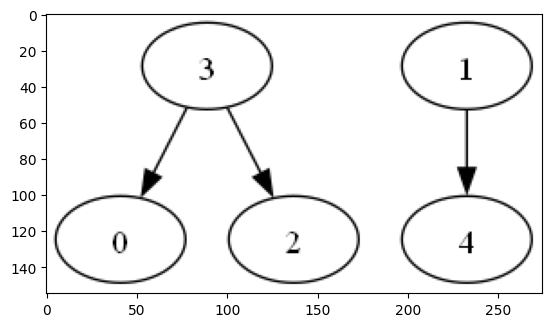

In [159]:
cm.PrintGraph(graph, filename="graph_part_2")
plt.imshow(plt.imread("graph_part_2.png"))

2.5) **Question: Which mode of transport are in the kernel?**

Answer: Bike and Train

# Part 3: Kernel

3.1) Given is the below outranking matrix

In [160]:
outranking_matrix = np.array(   [[0., 1., 0., 0., 0., 0., 1., 0.],
                                 [0., 0., 1., 0., 1., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0., 0., 1.],
                                 [0., 0., 0., 0., 1., 0., 1., 0.],
                                 [0., 0., 0., 0., 0., 1., 0., 0.],
                                 [0., 0., 0., 0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 0., 0., 0., 1.],
                                 [0., 0., 0., 0., 0., 0., 0., 0.]]) 

In [161]:
graph = toAdjacencyList(outranking_matrix)

In [162]:
graph

{0: [1, 6], 1: [2, 4], 2: [7], 3: [4, 6], 4: [5], 5: [6], 6: [7], 7: []}

3.2) Display the outranking graph. **Question: Which alternatives belong to kernel?**

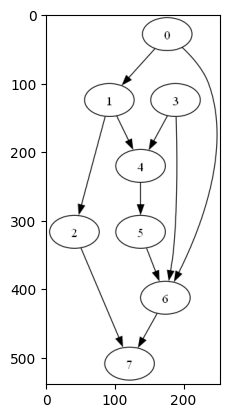

In [163]:
cm.PrintGraph(graph, filename="graph_part_3")
plt.imshow(plt.imread("graph_part_3.png"))

Answer: Kernel: (0,3,2,5)

3.3) In this exercise, you are asked to complete the function for constructing a kernel. Firstly, complete the below auxiliary function which reverses edges of the graph (i.e., constructs reversed adjancency dictionary)

In [164]:
def getReverseGraph(graph):
    n = len(graph)
    reverse_graph = {i:[] for i in graph}
    for i in range (n):
        for j in range(len(graph[i])):
            reverse_graph[graph[i][j]].append(i) 
    
    return reverse_graph

3.4) Verify the correctness: compare the below reverse_graph with the above graph variable.

In [165]:
reverse_graph = getReverseGraph(graph)
reverse_graph

{0: [], 1: [0], 2: [1], 3: [], 4: [1, 3], 5: [4], 6: [0, 3, 5], 7: [2, 6]}

3.2) Now, complete the below function for finding a graph kernel. This algorithm should proceed in the following way: <br>
1) Find non-outranked vertices. Add them to the kernel. <br> 
2) Remove the already found vertices from the graph and these vertices which are surpassed by them.<br>
3) Repeat (go to 1) until all vertices are removed from the graph. 

You can use the auxiliary reverse_graph structure. It can be helpfull for finding non-outranked vertices.

In [166]:
def Kernel(given_graph):
    kernel = []
    found = True
    steps = 0
    processed = [0 for _ in range (len(given_graph))]
    while(found == True):
        found = False
        reverse_graph = getReverseGraph(given_graph)
        forRemoval = []
        for i in range (len(reverse_graph)):
            if(processed[i] == 1):
                continue
            if(reverse_graph[i] == []):
                found = True
                kernel.append(i)
                forRemoval.append(i)
                for k in range (len(given_graph[i])):
                    if graph[i][k] not in forRemoval:
                        forRemoval.append(given_graph[i][k])
        for r in forRemoval:
            processed[r] = 1
            given_graph[r] = []
        steps+=1
                
    return kernel

In [167]:
print(Kernel(graph))

[0, 3, 2, 5]
